In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root="./data/MNIST", train=True, transform=transform, download=True)

test_dataset = datasets.MNIST(root="./data/MNIST", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=False) #num_workers= GPU 갯수
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

In [3]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim, fc2_input_dim):
        super().__init__()

        self.encoder_cnn = nn.Sequential( nn.Conv2d(1, 8, 3, stride=2, padding=1),
                                          nn.ReLU(True),
                                          nn.Conv2d(8, 16, 3, stride=2, padding=1),
                                          nn.BatchNorm2d(16),
                                          nn.ReLU(True),
                                          nn.Conv2d(16, 32, 3, stride=2, padding=0),
                                          nn.ReLU(True))
        self.flatten = nn.Flatten(start_dim=1)
        self.encoder_lin = nn.Sequential(nn.Linear( 3* 3* 32, 128),
                                         nn.ReLU(True),
                                         nn.Linear(128, encoded_space_dim))

    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x


In [4]:
class Decoder(nn.Module):
    def __init__(self, encoded_space_dim, fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential( nn.Linear(encoded_space_dim, 128),
                                          nn.ReLU(True),
                                          nn.Linear(128, 3* 3* 32),
                                          nn.ReLU(True))
        self.unflatten = nn.Unflatten(dim=1, 
                                      unflattened_size=(32, 3, 3))
        self.decoder_conv = nn.Sequential( nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
                                           nn.BatchNorm2d(16),
                                           nn.ReLU(True),
                                           nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
                                           nn.BatchNorm2d(8),
                                           nn.ReLU(True),
                                           nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1))

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x
        





In [5]:
encoder = Encoder(encoded_space_dim=4, fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=4, fc2_input_dim=128)

encoder.to(device)
decoder.to(device)

params_to_optimize = [ #인코더와 디코더에서 사용할 파라미터를 다르게 지정
    {'params':encoder.parameters()},
    {'params':decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=0.001, weight_decay=1e-05)
loss_fn=torch.nn.MSELoss()

### 훈련 함수, return은 평균 손실

In [6]:
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer, noise_factor=0.3):
    encoder.train() #학습입니다
    decoder.train() 
    train_loss=[]
    
    for image_batch, _ in dataloader: #비지도 학습이므로 y_label 필요 없음
        image_noisy = add_noise(image_batch, noise_factor) #멀쩡한 이미지에 노이즈 더하기
        image_noisy = image_noisy.to(device)
        encoded_data = encoder(image_noisy) #노이즈가 들어간 이미지를 인코더에 넣어서 벡터 출력
        decoded_data = decoder(encoded_data) #그 벡터를 디코더에 입력하여 노이즈가 제거된 이미지 생성
        loss = loss_fn(decoded_data, image_noisy) #노이즈 이미지와 노이즈 제거 이미지 사이의 값을 측정함
        #왜냐하면 decoder는 노이즈 잘 제거하는게 목적이므로
        #디코더의 성능을 평가하기 위해 loss_fn에 위 두개가 들어감
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)

### 검증 함수

In [7]:
def test_epoch(encoder, decoder, device, dataloader, loss_fn, noise_factor=0.3):
    encoder.eval() #평가입니다
    decoder.eval()

    #테스트 과정에서는 모델 성능 평가 위해서 
    #모델의 출력(복원된 이미지) 와, 원본 이미지 를 비교함. 이걸 기억해야함

    
    with torch.no_grad(): #메모리사용줄이기
        conc_out = [] #디코더가 생성해낸 복원된 이미지. 평가 대상
        conc_label = [] #노이즈도 없고 건드려지지않은 깨끗한 이미지. 정답. 비교 대상
        for image_batch, _ in dataloader:
            image_batch = image_batch.to(device)
            encoded_data = encoder(image_batch) #입력 이미지 인코딩 
            decoded_data = decoder(encoded_data)
            conc_out.append(decoded_data.cpu()) #디코더의 출력을 리스트에 저장함
            conc_label.append(image_batch.cpu()) #입력 이미지를 저장함
        conc_out = torch.cat(conc_out) #리스트 형식으로 저장된 모든 값을 하나의 텐서로 결합
        conc_label = torch.cat(conc_label) # 리스트 형식으로 저장된 모든 레이블을 하나의 텐서로 결합
        val_loss = loss_fn(conc_out, conc_label)  # 디코더의 출력과 입력 이미지 사이의 손실을 계산
    return val_loss.data

### 이미지에 노이즈 더해주는 함수생성

In [8]:
def add_noise(inputs, noise_factor=0.3):
    noisy = inputs + torch.randn_like(inputs) * noise_factor #inputs과 동일한 크기의 노이즈 텐서 생성
    noisy = torch.clip(noisy, 0., 1.) #clip(값의 범위를 조정할 데이터셋, 최솟값, 최댓값)
    return noisy

In [9]:
plt.rcParams["font.family"]='Malgun Gothic'

### 모델 훈련 및 평가 시 이미지를 시각적으로 보기 위한 함수 생성

In [10]:
def plot_ae_outputs(encoder, decoder, n=5, noise_factor=0.3):
    plt.figure(figsize=(10, 4.5))
    for i in range(n):
        ax = plt.subplot(3, n, i+1)
        img = test_dataset[i][0].unsqueeze(0)
        image_noisy = add_noise(img, noise_factor)
        image_noisy = image_noisy.to(device)

        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img = decoder(encoder(image_noisy))

        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n//2:
            ax.set_title("원래 이미지")
        ax = plt.subplot(3, n, i+1+n)
        plt.imshow(image_noisy.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n//2:
            ax.set_title("노이즈가 적용되어 손상된 이미지")

        ax = plt.subplot(3, n, i+1+n+n)
        plt.imshow(rec_img.squeeze().numpy(), cmap='gist_gray')        
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n//2:
            ax.set_title("재구성된 이미지")

    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.7,
                        top=0.9,
                        wspace=0.3,
                        hspace=0.3)
    plt.show()


### 모델 훈련, 검증, 기록 시각화

EPOCH 1/30

 EPOCH 1/30 	 train loss 0.070 	 val loss 0.048


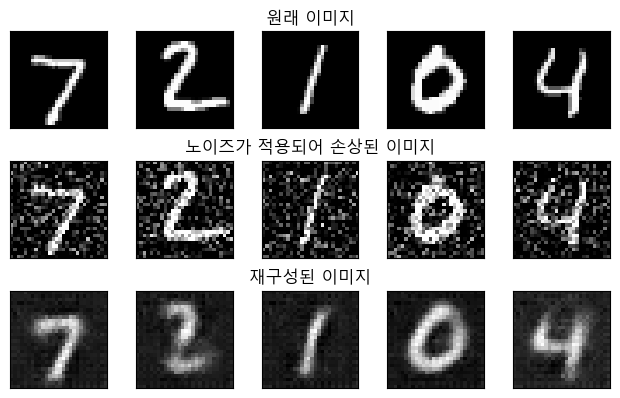

EPOCH 2/30

 EPOCH 2/30 	 train loss 0.054 	 val loss 0.044


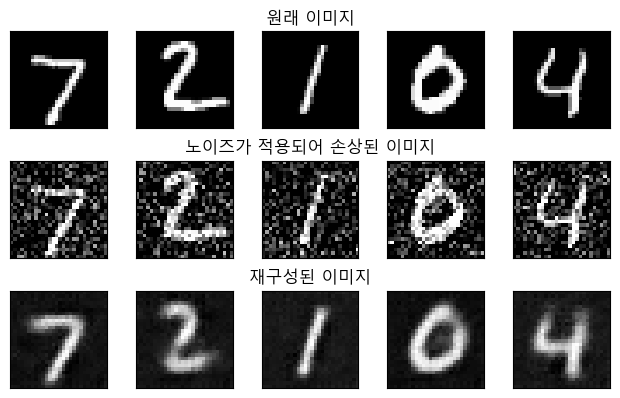

EPOCH 3/30

 EPOCH 3/30 	 train loss 0.053 	 val loss 0.042


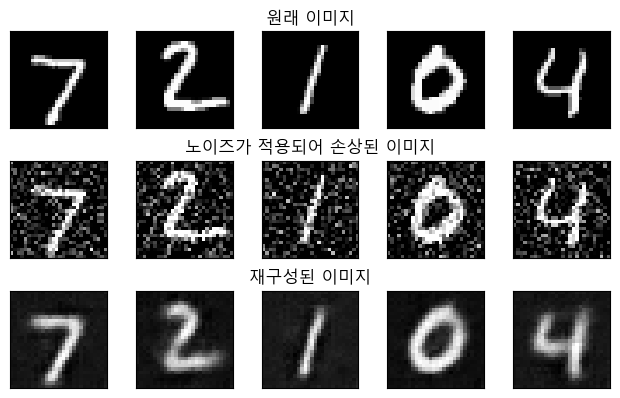

EPOCH 4/30

 EPOCH 4/30 	 train loss 0.052 	 val loss 0.042


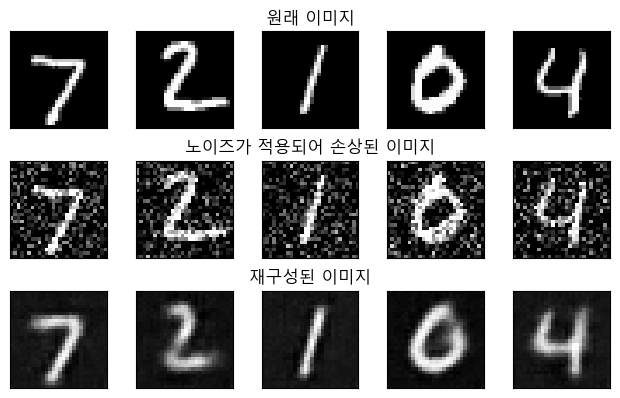

EPOCH 5/30

 EPOCH 5/30 	 train loss 0.052 	 val loss 0.041


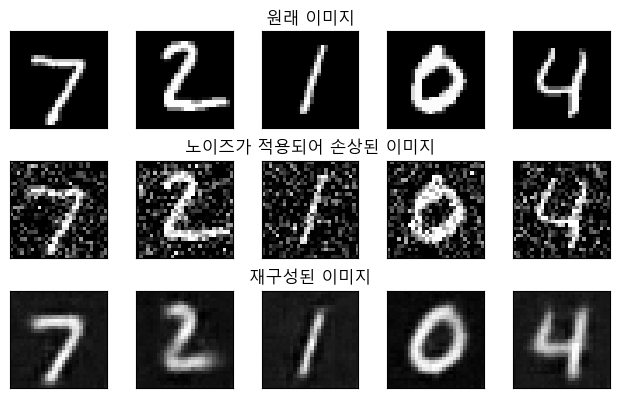

EPOCH 6/30

 EPOCH 6/30 	 train loss 0.051 	 val loss 0.040


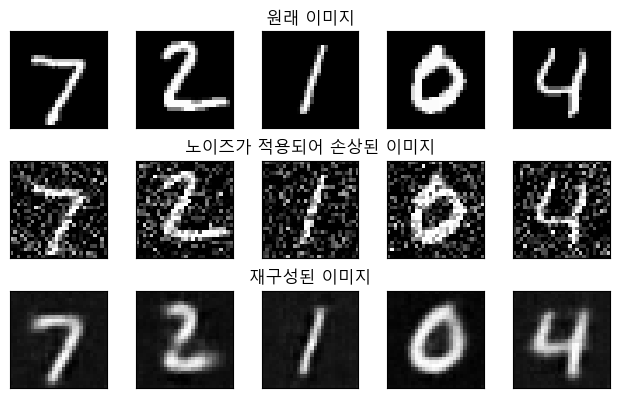

EPOCH 7/30

 EPOCH 7/30 	 train loss 0.051 	 val loss 0.040


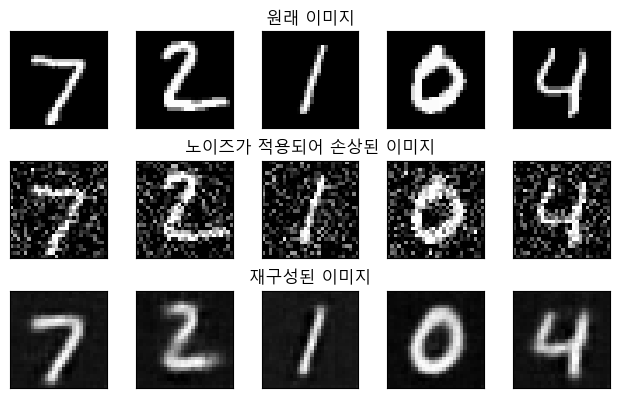

EPOCH 8/30

 EPOCH 8/30 	 train loss 0.051 	 val loss 0.040


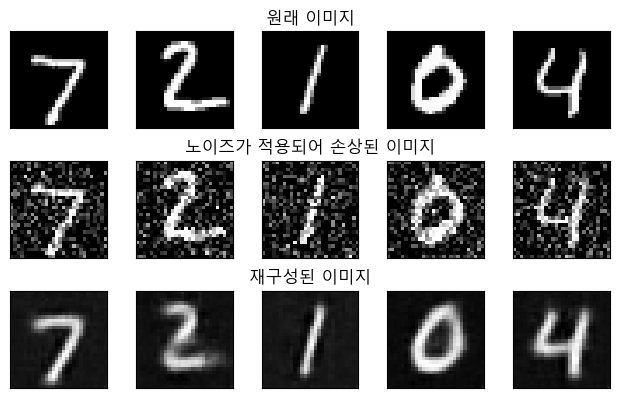

EPOCH 9/30

 EPOCH 9/30 	 train loss 0.051 	 val loss 0.039


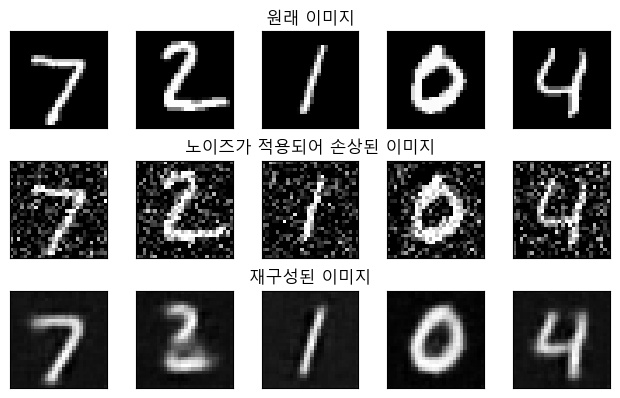

EPOCH 10/30

 EPOCH 10/30 	 train loss 0.050 	 val loss 0.039


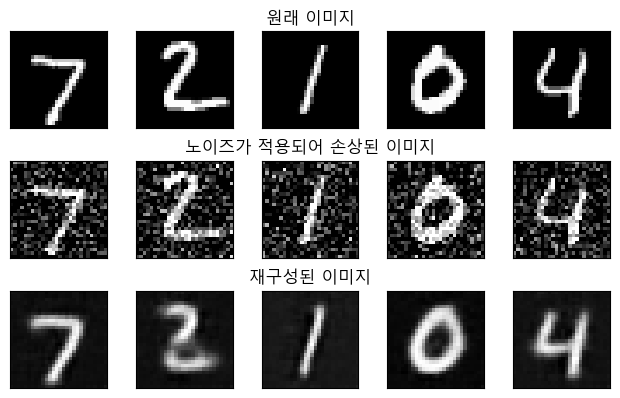

EPOCH 11/30

 EPOCH 11/30 	 train loss 0.050 	 val loss 0.039


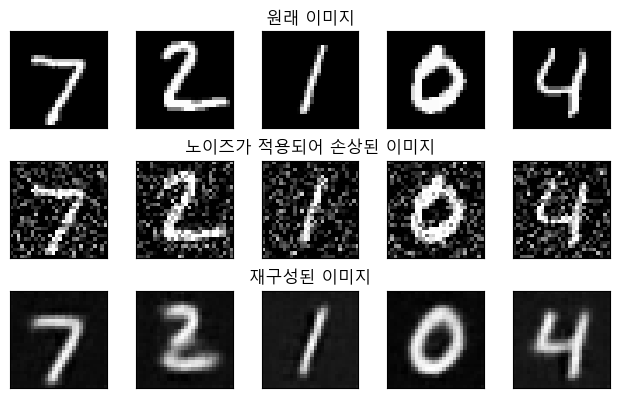

EPOCH 12/30

 EPOCH 12/30 	 train loss 0.050 	 val loss 0.039


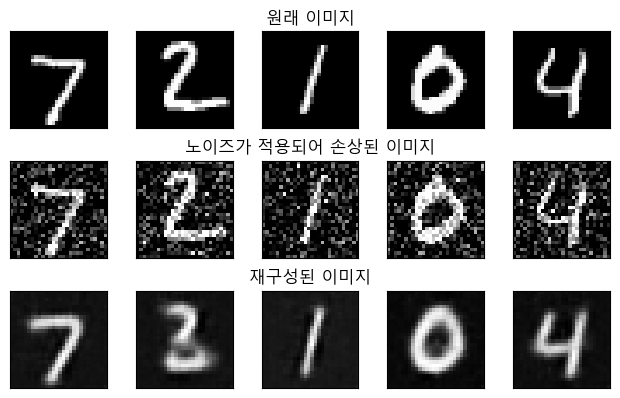

EPOCH 13/30

 EPOCH 13/30 	 train loss 0.050 	 val loss 0.039


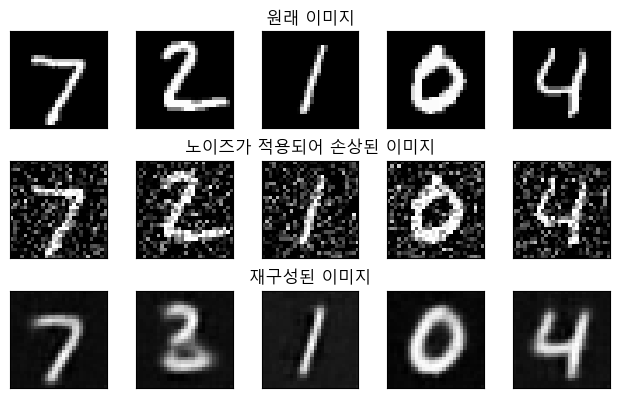

EPOCH 14/30

 EPOCH 14/30 	 train loss 0.050 	 val loss 0.039


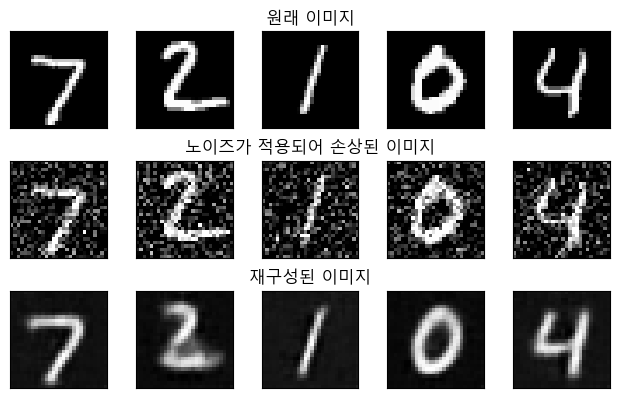

EPOCH 15/30

 EPOCH 15/30 	 train loss 0.050 	 val loss 0.039


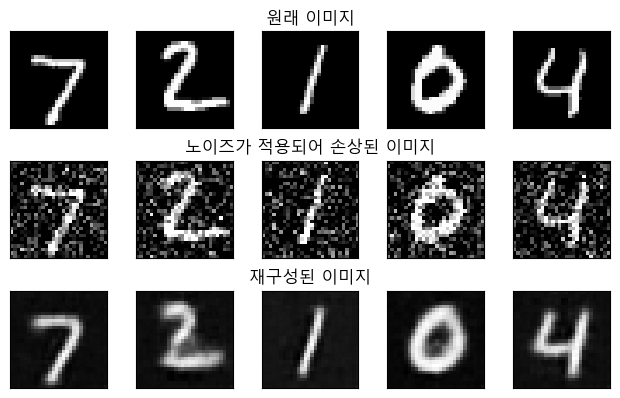

EPOCH 16/30

 EPOCH 16/30 	 train loss 0.050 	 val loss 0.039


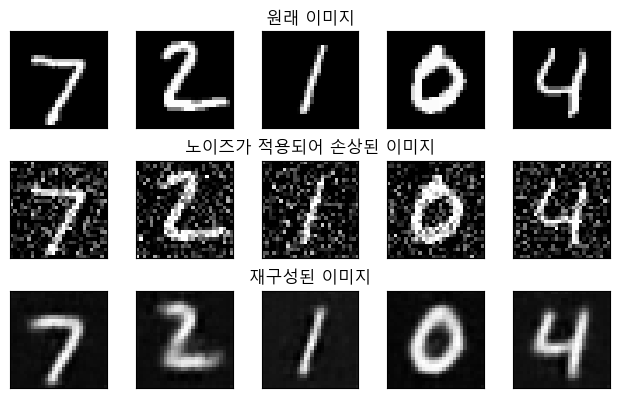

EPOCH 17/30

 EPOCH 17/30 	 train loss 0.050 	 val loss 0.039


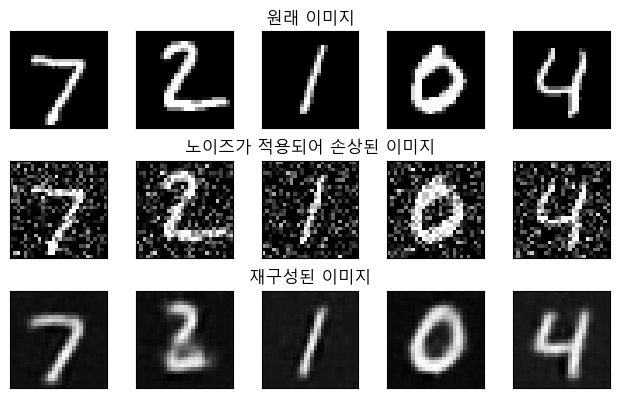

EPOCH 18/30

 EPOCH 18/30 	 train loss 0.050 	 val loss 0.038


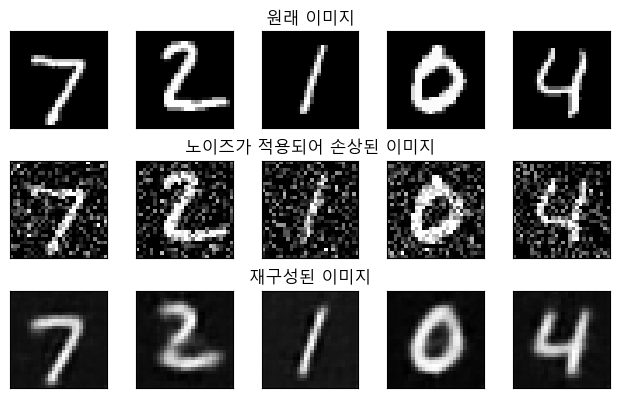

EPOCH 19/30

 EPOCH 19/30 	 train loss 0.050 	 val loss 0.038


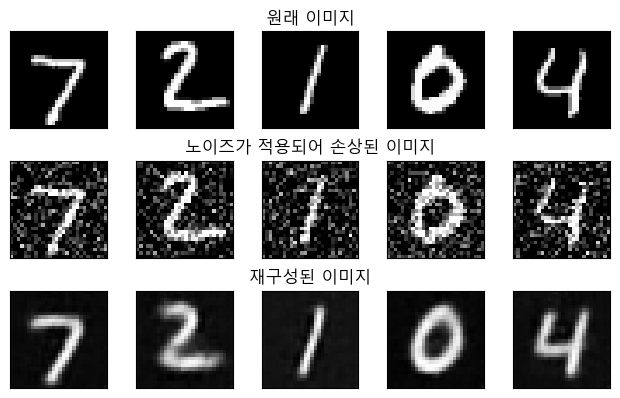

EPOCH 20/30

 EPOCH 20/30 	 train loss 0.050 	 val loss 0.038


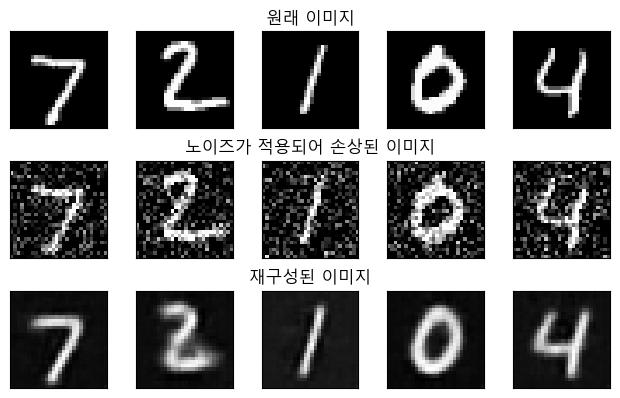

EPOCH 21/30

 EPOCH 21/30 	 train loss 0.050 	 val loss 0.038


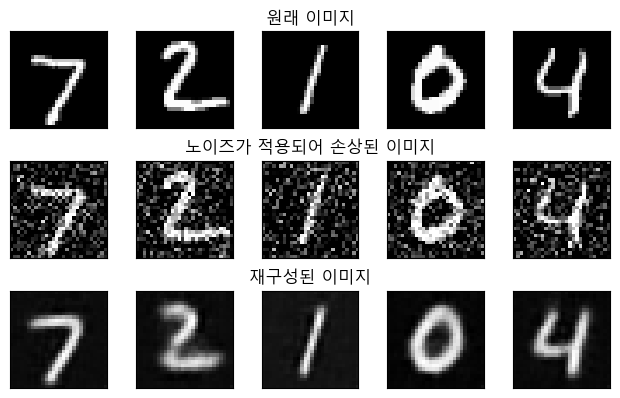

EPOCH 22/30

 EPOCH 22/30 	 train loss 0.050 	 val loss 0.038


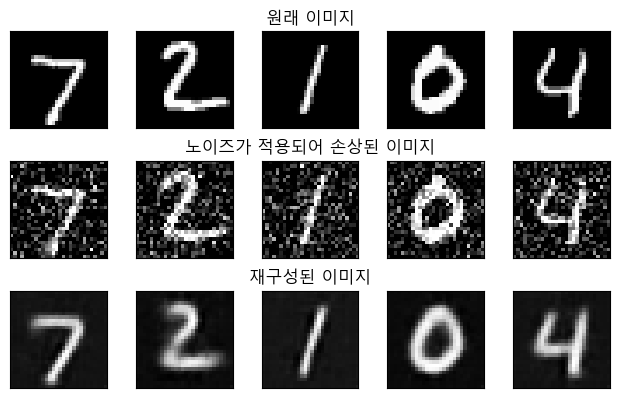

EPOCH 23/30

 EPOCH 23/30 	 train loss 0.050 	 val loss 0.038


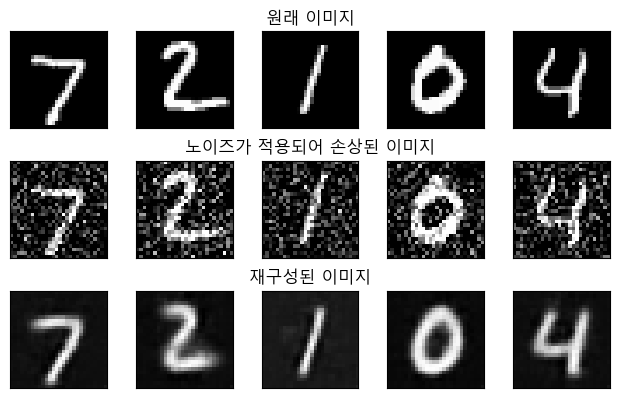

EPOCH 24/30

 EPOCH 24/30 	 train loss 0.049 	 val loss 0.038


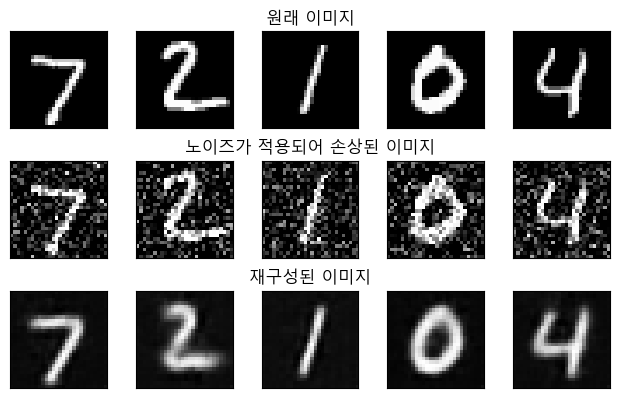

EPOCH 25/30

 EPOCH 25/30 	 train loss 0.049 	 val loss 0.038


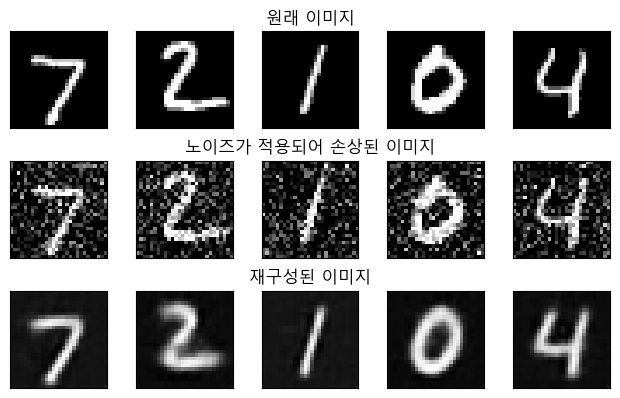

EPOCH 26/30

 EPOCH 26/30 	 train loss 0.049 	 val loss 0.038


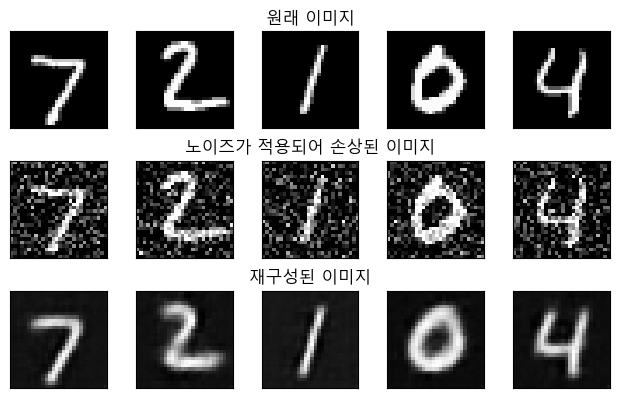

EPOCH 27/30

 EPOCH 27/30 	 train loss 0.049 	 val loss 0.038


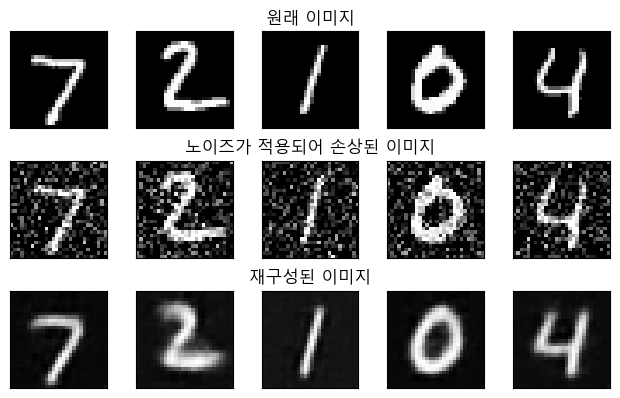

EPOCH 28/30

 EPOCH 28/30 	 train loss 0.049 	 val loss 0.038


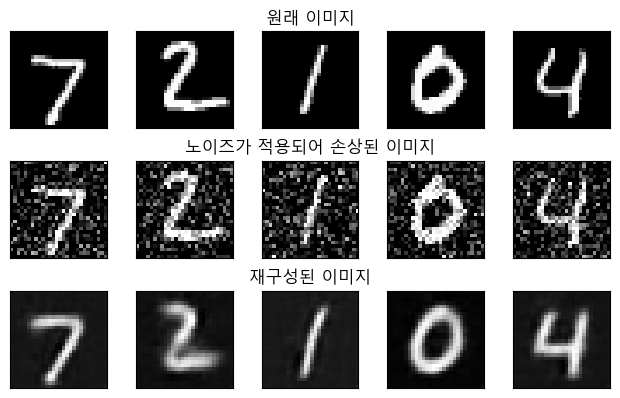

EPOCH 29/30

 EPOCH 29/30 	 train loss 0.049 	 val loss 0.038


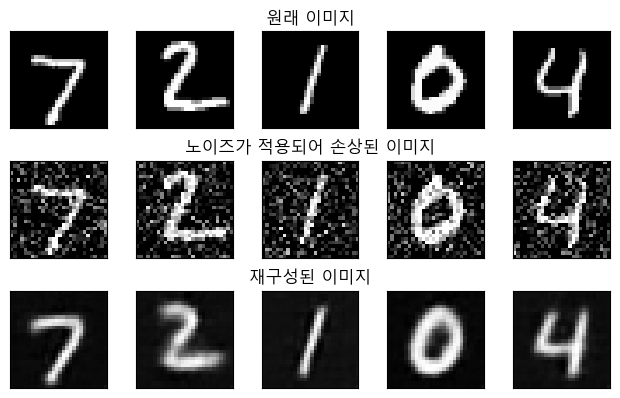

EPOCH 30/30

 EPOCH 30/30 	 train loss 0.049 	 val loss 0.038


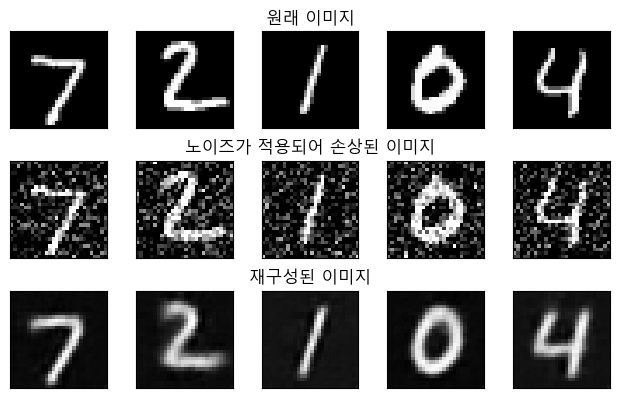

In [11]:
import numpy as np

num_epochs = 30
history_da = {'train_loss':[], 'val_loss':[]}
loss_fn = torch.nn.MSELoss()

for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch+1, num_epochs))
    train_loss=train_epoch( #아까 만들어둔 train_epoch 함수에 파라미터 부여함
        encoder=encoder,
        decoder=decoder,
        device=device,
        dataloader=train_loader,
        loss_fn=loss_fn,
        optimizer=optim, noise_factor=0.3) #출력은 mean으로 훈련데이터의 평균 손실값 
    val_loss=test_epoch(
        encoder=encoder,
        decoder=decoder,
        device=device,
        dataloader=test_loader,
        loss_fn=loss_fn, noise_factor=0.3)
    history_da['train_loss'].append(train_loss) #학습과정 모니터링을 위한 기록리스트
    history_da['val_loss'].append(val_loss)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch+1, num_epochs, train_loss, val_loss))
    plot_ae_outputs(encoder, decoder, noise_factor=0.3)